# Regression Analysis
Classification(분류)과 더불어 Supervised Learning(지도 학습)의 중요 부분. $y$가 이산형이면 분류, 연속형이면 회귀.

## Linear Regression
$\mathbb{y} = \beta^T \mathbb{x}$ 에서 $\beta$를 추정하는 것. 어떻게?
    
$\sum{\epsilon^2} = \sum{(y_i - \beta^T x_i)^2}$를 최소화하는 $\beta$ 찾기. $\beta$는 모수이므로 추정하면 $\hat{\beta} = (X^TX)^{-1}X^Ty$

## RANSAC
**RAN** **SA**mple **C**onsensus. 빅데이터에서 Robust Regression을 수행하는 방법.
* 목적 : 선형회귀는 outlier(이상치)에 민감하기 때문에 이를 보완하고자 함.
* 과정
    1. 학습데이터에서 작은 크기의 임의 표본을 뽑음. (특성변수 총수 + 20~30개)
    2. 표본에 OLS추정치를 구함.
    3. 이후 추정된 모형에 전체 학습데이터를 적용하여 잔차를 구함.
    4. 잔차의 중위수( $median(r_i)$ )를 구한 후 각 잔차의 MAD( $|r_i - median(r_i)|$ )를 구함.
    5. MAD가 $d$ (보통 4~5)보다 작은 관측치만 모음 -> concensus set
    6. consensus set에 OLS를 재적합.
    7. step1~step6를 $M$번 반복한다.
    8. 가장 큰 크기의 consensus set으로 계산된 OLS 추정치 사용
* Hyperparameter : 표본의 수, $d$, $M$

## SVR
SVC와 개념적으로 동일하다. 모든 $(x_i, y_i)$에 대하여 $|y_i - \beta^T x_i| \leq \epsilon_i$ 인 $\beta$를 찾는 것이 목적이다. 상위 support vector( $(x_+, y_+)$ )와 하위 support vector( $(x_-, y_-)$ )에 대해 두 직선 사이의 거리는

$$y_+ - y_- + \beta^T(x_- - x_+) = 2\epsilon$$
이고 양변을 $|\beta|$로 나누면,

$$\frac{y_+ - y_- + \beta^T(x_- - x_+)}{|\beta|} = \frac{2\epsilon}{|\beta|}$$ 이다.

즉, 표준화된 거리를 최대화하는 것은 $|\beta|$(결국 $|\beta|^2$)를 최소화하는 것과 동일하다. 하지만, 실제로는 $\epsilon$이 매우 크지 않는 한 맨 처음 부등식을 만족하기는 쉽지 않다. 따라서 SVC처럼 완화변수($\zeta_i, \zeta_i^*$)를 도입한다. 다시 말해

$$ y_i - x_i^T \beta \leq \epsilon + \zeta_i \text{ and } x_i^T - y_i \beta \leq \epsilon + \zeta_i^*  \text{ where } \zeta_i \zeta_i^* >0$$

를 만족하는 $\beta$를 찾아야 하며 이는 $|\beta|^2 + C\sum{(\zeta_i + \zeta_i^*)}$를 최소화하는 문제로 귀결된다.

## Ridge Regression
$L_2$ Regularization라고도 부르며, overfitting에 대한 해결책으로 사용한다. 설명력이 부족한 변수들의 계수를 0에 가까운 값으로 수렴시킨다. 통계학에서는 $X^TX$의 역행렬이 존재하지 않을 경우 사용했으나 해석이 어려웠다. 하지만, $L_2$ 규제화로 해석이 가능해졌다.

$\hat{\beta}^{Ridge} = (X^TX + \lambda I)^{-1}X^TY$ 는 $[\sum{(y_i-x_i^T\beta)^2} + \lambda \sum{\beta_k^2}]$를 최소화하는 $\beta$의 추정치이다. $\lambda$를 조절하여 적절한 $\hat{\beta}^{Ridge}$를 찾는다.

## LASSO Regression
$L_1$ Regularization라고도 부르며, Ridge regression과 비슷하지만, $\hat{\beta}^{LASSO}$ 는 $[\sum{(y_i-x_i^T\beta)^2} + \lambda \sum{|\beta_k|}]$를 최소화하는 $\beta$의 추정치라는 점에서 차이가 있다. 또한, LASSO는 설명력이 부족한 변수들의 계수에 0의 값을 준다.

## Example
아래의 코드는 Ridge regression과 LASSO regression의 차이를 살펴보는 내용이다.

In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [2]:
sns.set()

직선으로 회귀하기에는 적합하지 않은 데이터 생성

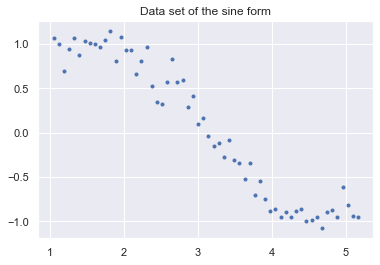

In [17]:
x = np.array([i*np.pi/180 for i in range(60,300,4)])
np.random.seed(10)
y = np.sin(x) + np.random.normal(0,0.15,len(x))
data = pd.DataFrame(np.column_stack([x,y]),columns=['x','y'])
plt.plot(data['x'],data['y'],'.')
plt.title('Data set of the sine form')
plt.show()

$x^2$부터 $x^{15}$까지 추가한다.

In [18]:
for i in range(2,16):
    colname = 'x^%d'%i
    data[colname] = data['x']**i

In [103]:
data.head()

,x,y,x^2,x^3,x^4,x^5,x^6,x^7,x^8,x^9,x^10,x^11,x^12,x^13,x^14,x^15
0,1,1.1,1.1,1.1,1.2,1.3,1.3,1.4,1.4,1.5,1.6,1.7,1.7,1.8,1.9,2
1,1.1,1,1.2,1.4,1.6,1.7,1.9,2.2,2.4,2.7,3,3.4,3.8,4.2,4.7,5.3
2,1.2,0.7,1.4,1.7,2,2.4,2.8,3.3,3.9,4.7,5.5,6.6,7.8,9.3,11,13
3,1.3,0.95,1.6,2,2.5,3.1,3.9,4.9,6.2,7.8,9.8,12,16,19,24,31
4,1.3,1.1,1.8,2.3,3.1,4.1,5.4,7.2,9.6,13,17,22,30,39,52,69


In [19]:
X=data.drop('y',axis=1)
y=data['y']

### Linear Regression
각각 1,3,6,9,12,15차까지의 변수를 사용하여 선형회귀를 수행한다.

In [99]:
col=['intercept']+['coef_x^%d'%p for p in range(1,16)]
ind=['pow_%d'%p for p in (1,3,6,9,12,15)]
coef_lin=pd.DataFrame(columns=col,index=ind)

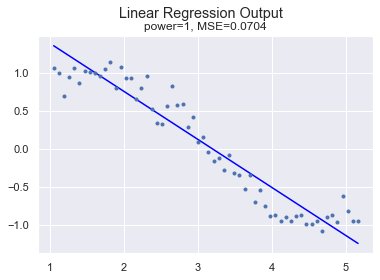

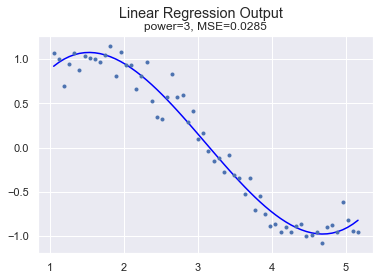

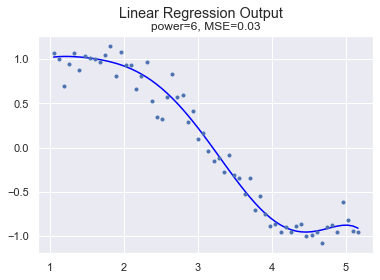

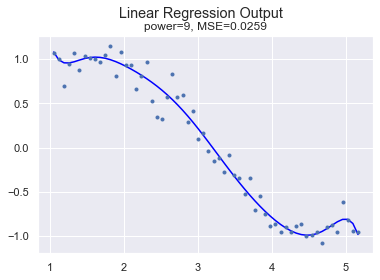

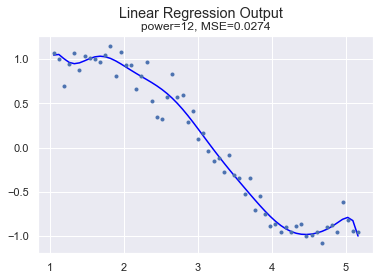

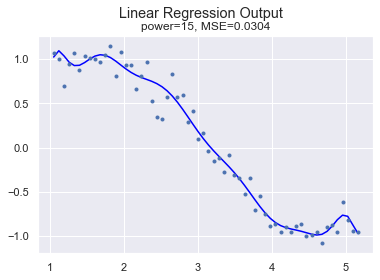

In [100]:
i=0
for p in (1,3,6,9,12,15):
    X_train, X_test, y_train, y_test = train_test_split(X.iloc[:,:p], y, test_size=0.3, random_state=10)
    lin=LinearRegression()
    lin.fit(X_train, y_train)
    y_pred_lin=lin.predict(X_test)
    coef_lin.iloc[i,0]=lin.intercept_
    coef_lin.iloc[i,1:p+1]=lin.coef_
    i+=1
    
    plt.plot(data['x'],(lin.coef_*X.iloc[:,:p]).sum(axis=1)+lin.intercept_,color='blue')
    plt.plot(data['x'],y,'.')
    plt.suptitle('Linear Regression Output')
    plt.title('power=%d, MSE=%.3g' % (p, mean_squared_error(y_pred_lin, y_test)))
    plt.show()

In [101]:
pd.options.display.float_format = '{:,.2g}'.format
coef_lin

,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
pow_1,2,-0.63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pow_3,-0.82,2.8,-1.2,0.13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pow_6,-0.7,5.1,-6.1,3.8,-1.3,0.2,-0.012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pow_9,83,-3e+02,4.8e+02,-4.2e+02,2.3e+02,-84,19,-2.8,0.23,-0.0084,NaN,NaN,NaN,NaN,NaN,NaN
pow_12,-1.3e+03,6.6e+03,-1.5e+04,2e+04,-1.7e+04,1e+04,-4.4e+03,1.3e+03,-2.9e+02,43,-4.3,0.25,-0.0067,NaN,NaN,NaN
pow_15,-7.5e+02,2.6e+03,-2.9e+03,-1.6e+02,2.6e+03,-1.1e+03,-1.8e+03,2.9e+03,-2e+03,9e+02,-2.7e+02,56,-8,0.75,-0.042,0.001


### Lasso Regression
사용하는 차수를 굳이 우리가 조절하지 않고 $\alpha$만을 조절하여 계수를 찾는다. 설명력이 부족한 변수는 0을 계수로 가지는 것을 확인할 수 있다.

In [84]:
ind = ['alpha_%.2g' %alpha for alpha in [0.00001,0.0001,0.001, 0.01, 0.1,1]]
coef_las = pd.DataFrame(columns=col, index=ind)

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1394353747464701, tolerance: 0.002835894632796353
  positive)


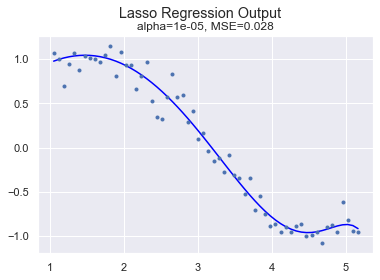

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:475: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.044925319435393296, tolerance: 0.002835894632796353
  positive)


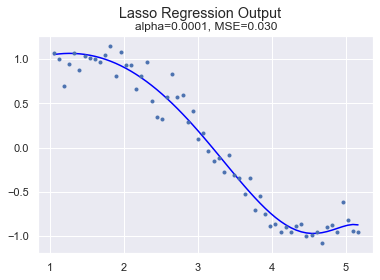

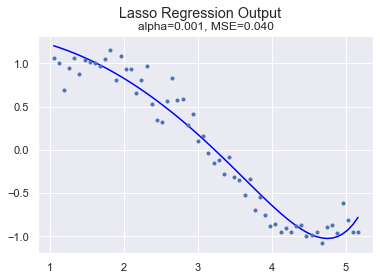

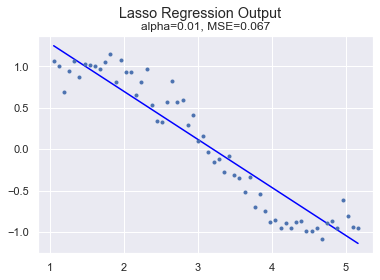

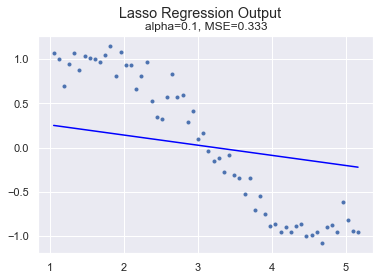

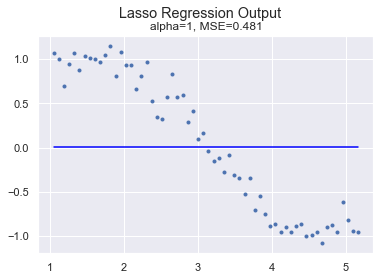

In [86]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)
i=0
for alpha in [0.00001,0.0001,0.001, 0.01, 0.1,1]:
    las=Lasso(alpha=alpha,normalize=True, max_iter=1000)
    las.fit(X_train, y_train)
    y_pred_las=las.predict(X_test)
    coef_las.iloc[i,0]=las.intercept_
    coef_las.iloc[i,1:]=las.coef_
    i+=1
    
    plt.plot(data['x'],(las.coef_*X).sum(axis=1)+las.intercept_,color='blue')
    plt.plot(data['x'],y,'.')
    plt.suptitle('Lasso Regression Output')
    plt.title('alpha=%.4g, MSE=%.3f' % (alpha, mean_squared_error(y_pred_las, y_test)))
    plt.show()

In [92]:
pd.options.display.float_format = '{:,.2g}'.format
coef_las

,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
alpha_1e-05,0.28,0.99,-0.29,-0.023,-0.00041,0.0002,9.1e-05,1.8e-05,2.9e-06,4e-07,4.3e-08,2e-09,0,-2.2e-10,-9.9e-11,-2.5e-11
alpha_0.0001,0.65,0.62,-0.21,-0.021,-0,-0,3.2e-05,2.2e-05,3e-06,3.3e-07,1.3e-08,0,0,-0,-0,-3.3e-11
alpha_0.001,1.3,-0,-0.13,-0,-0,0,0,0,0,0,7.3e-08,5.3e-09,0,0,0,0
alpha_0.01,1.9,-0.58,-0,-0,-0,-0,-0,-0,0,0,0,0,0,0,0,0
alpha_0.1,0.37,-0.11,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0
alpha_1,0.0061,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0,-0


### Rigde Regression
계수가 0에 수렴할 뿐 0이지는 않다.

In [89]:
ind = ['alpha_%.2g' %alpha for alpha in [1e-15,0.001,0.01,0.1,1,10]]
coef_rid = pd.DataFrame(columns=col, index=ind)

/Users/joshua/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.63829e-17): result may not be accurate.
  overwrite_a=True).T


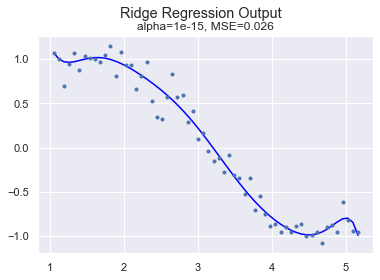

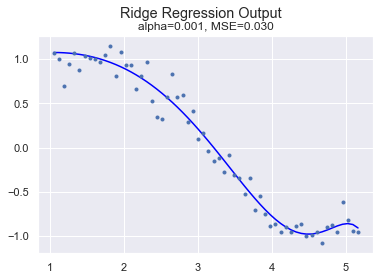

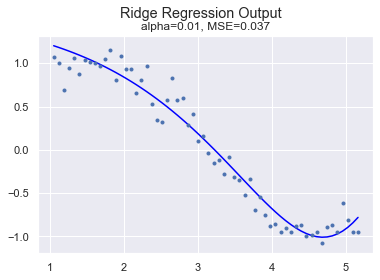

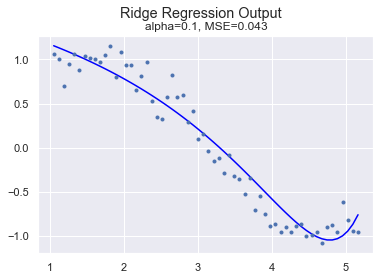

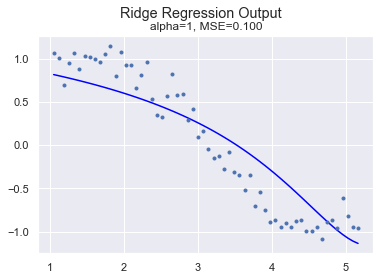

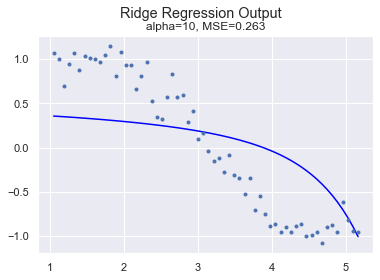

In [90]:
i=0
for alpha in [1e-15,0.001,0.01,0.1,1,10]:
    rid=Ridge(alpha=alpha, normalize=True)
    rid.fit(X_train, y_train)
    y_pred_reg=rid.predict(X_test)
    coef_rid.iloc[i,0]=rid.intercept_
    coef_rid.iloc[i,1:]=rid.coef_
    i+=1
    
    plt.plot(data['x'],(rid.coef_*X).sum(axis=1)+rid.intercept_,color='blue')
    plt.plot(data['x'],y,'.')
    plt.suptitle('Ridge Regression Output')
    plt.title('alpha=%.4g, MSE=%.3f' % (alpha, mean_squared_error(y_pred_reg, y_test)))
    plt.show()

In [93]:
pd.options.display.float_format = '{:,.2g}'.format
coef_rid

,intercept,coef_x^1,coef_x^2,coef_x^3,coef_x^4,coef_x^5,coef_x^6,coef_x^7,coef_x^8,coef_x^9,coef_x^10,coef_x^11,coef_x^12,coef_x^13,coef_x^14,coef_x^15
alpha_1e-15,26,-63,49,9.9,-38,25,-7.3,0.71,0.12,-0.02,-0.0058,0.0012,0.00018,-7.2e-05,8e-06,-3.2e-07
alpha_0.001,0.92,0.26,-0.084,-0.02,-0.0028,-0.00022,1.7e-05,1.2e-05,3.4e-06,7.3e-07,1.3e-07,1.9e-08,1.7e-09,-1.5e-10,-1.4e-10,-5.2e-11
alpha_0.01,1.4,-0.13,-0.052,-0.0095,-0.0013,-0.00011,2.8e-06,4.3e-06,1.3e-06,2.9e-07,5.4e-08,8.4e-09,1e-09,2.6e-11,-3.4e-11,-1.5e-11
alpha_0.1,1.5,-0.24,-0.034,-0.005,-0.00069,-8.3e-05,-7.7e-06,-1.5e-07,1.7e-07,6.1e-08,1.5e-08,3.4e-09,6.8e-10,1.3e-10,2.3e-11,3.7e-12
alpha_1,0.99,-0.14,-0.019,-0.0029,-0.00045,-6.9e-05,-9.9e-06,-1.3e-06,-1.6e-07,-1.3e-08,5e-10,6.1e-10,2.1e-10,5.5e-11,1.3e-11,3e-12
alpha_10,0.4,-0.037,-0.0054,-0.00093,-0.00017,-3e-05,-5.3e-06,-9.4e-07,-1.7e-07,-3e-08,-5.4e-09,-9.5e-10,-1.7e-10,-3e-11,-5.4e-12,-9.6e-13
